# Introducing The IgnoringBiasEstimator
Recently, a friend of mine, 26 years old, told me about her experience interviewing for a resident position (_"arts in opleiding tot specialist (aios)"_ in Dutch). Everything went well and she got the position. But she did tell me one specificic part of the conversation that baffled me: when planning her educational program for the next ten years, the dean just planned her maternity leave with it - not that she's pregnant, but he already planned it because he figured she would. I probably shouldn't have been surprised. Many female friends have shared similar experiences since.

Now this blog is about AI, but AI is about the real world. In the real world, biases often lead to uneven outcomes. In the story above, my friend did get the position, but in many instances, groups may be disadvantaged. When these decision processes would be automated through AI, the model might learn the biases with it: perphaps that it should hire females at a smaller rate. This has in fact happened on many occasions [in the real world](https://towardsdatascience.com/real-life-examples-of-discriminating-artificial-intelligence-cae395a90070), and was a driver for one of the biggest scandals in the Netherlands in recent years: the ["Toeslagenaffaire"](https://www.rtlnieuws.nl/nieuws/nederland/artikel/5037966/belastingdienst-toeslagenaffaire-ministerie-van-financien).

While there is a lot of attention for bias mitigation in AI, I feel it is still lacking: it requires more work, gives worse outcomes and less flexibility. To me, this is unacceptable. I work for the organisation I do, because I feel it helps society. Therefore, I developed an easy wrapper around `sklearn`-models that mitigates biases. I call it the `IgnoringBiasEstimator`. It has the following advantages:
* It is **extremely easy to implement**, as it is just a wrapper around sklearn models that are ubiquitous in data science. I will investigate this in this Part 1 of the series.
* It is **very flexible**: unlike many bias mitigation algorithms, it works with both regression and classification and for both continuous and binary/categorical data. I will look into this further in further installments of the series.
* Most importantly, it **removes disparate treatment very well**,  also when the bias is non-linear and/or correlated, which I will also investigate further in next installments.
* As a bonus, it **gives insight in the current biases** in the data set, which may be used to decrease the bias in the real world as well. 

The IgnoringBiasEstimator consciously learns the bias in the data during training time, so it can adequately ignore it at prediction time.

## Outline
### The blog series
The introduction and comparison of the IgnoringEstimator is split into three parts
1. [Introducing the IgnoringEstimator](https://github.com/SjoerdCor/fairness/blob/main/blog/1.IntroducingTheIgnoringEstimator.ipynb) introduces measures of fairness and shows how naive approaches do not solve them, and on the other hand shows how easily the IgnoringEstimator is implemented and solves them well
1. [Dealing with more complex biases](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb) first shows how common complex biases are: non-linear, correlated with other attributes and for continuous features, and shows how easy it is to mitigate the disparate treatment with the `IgnoringBiasEstimator`. I also show how little attention there seems to be for this problem in existing approaches.
1. [Ignoring bias for cassification poblems](https://github.com/SjoerdCor/fairness/blob/main/blog/3.IgnoringBiasForClassificationProblems.ipynb) finally shows how to use the Ignoring Estimator for the classic classification problems - since these are more prolific, we can also compare against a wide variety of existing approaches and see the `IgnoringBiasEstimator` does equally well or better both in terms of bias mitigation and accuracy.

### This installment introduces the problem, measures of fairness and compares naive approaches with the IgnoringEstimator

* First, I will show the problem by generating a biased data set and showing how it leads to biased models
* For this, I will also define the notions of disparate impact and disparate treatment
* Secondly, I will show passive bias mitigation strategies of ignoring the sensitive attributes does not solve the problem if these attributes are correlated with other, non-sensitive attributes (as is often the case)
* Lastly, I will quickly show how to run the the IgnoringBiasEstimator and how well it does both in terms of fairness and accuracy. A deeper investigation will follow in parts 2 and 3. 


## Generating biased data: salaries for employees

To investigate fairness, imagine there is a company with 2500 employees that is concerned with salary differences, and they set out to give everyone a fair salary, but with the same mean salary. I generate a toy dataset consisting of three employee characteristics: Gender (0 or 1), Education (between 4 and 20) and Experience, a continuous variable between 0 and 40. It also has a SalaryTrue column, which is the monthly salary of each employee. The SalarySkill column contains what should be paid to each employee, if the salary were based purely on the skill. It is based on Education (150 per level) and experience (30 per level), with a standard deviation of 150 per employee for other characteristics. Unfortunately, in the true world, one does not observe this - one only observes the paid salary. 

Now imagine this company has a gender bias, where the people with gender 1 are structurally paid less 200 every month. This is what is observed in the SalaryTrue column.

<img src="./figures/DGP_Salary_Uncorrelated.PNG" title="The data generating process for salary for an imaginary company with biases in employee salaries"/>

In [1]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from fairness import fairestimator
from fairness.blog import utils

np.random.seed(42)

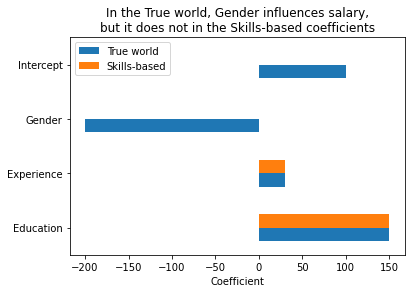

In [2]:
coefficients = pd.DataFrame({'True world': {'Education': 150, 'Experience': 30, 'Gender': -200, 'Intercept': 100},
                             'Skills-based': {'Education': 150, 'Experience': 30, 'Gender': 0, 'Intercept': 0}}
                           )

coefficients.plot(kind='barh', title='In the True world, Gender influences salary,\nbut it does not in the Skills-based coefficients')
plt.xlabel('Coefficient')
plt.show()

*Note that the intercept is 100 larger in the True world so that the same mean salary is paid for the entire company.*

In [3]:
def generate_employees_uncorrelated(size=2500):
    X = (pd.DataFrame({'Gender': np.random.randint(2, size=size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'Experience': 40*np.random.rand(size)
                      }
                     )         
        )
    return X

def add_salaries(df):
    weights = {'Gender': 0,
               'Education': 150,
               'Experience': 30,
              }
    gender_bias = -100 # -100 for Gender 1 and +100 for Gender 0, because Gender is standardized first
    error = np.random.normal(0, 150, size=len(df))
    df = df.assign(SalarySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   SalaryTrue = lambda df: df['SalarySkill'].add(utils.generate_bias(df['Gender'], effect_size=gender_bias)))
    return df

In [4]:
df = generate_employees_uncorrelated().pipe(add_salaries)
def display_df(df, n=10):
    display(df.sample(n, random_state=42)
              .style.format({'Education': "{:.2f}", 'Experience': '{:.2f}', 'Gender': "{:d}",
                             'SalarySkill': "€{:.2f}", 'SalaryTrue': '€{:.2f}'})
        )

display_df(df)

,Gender,Education,Experience,SalarySkill,SalaryTrue
1447,1,8.99,2.55,€1589.80,€1487.72
1114,0,13.24,12.55,€2692.03,€2789.95
1064,1,19.89,30.78,€3756.35,€3654.26
2287,0,9.69,34.95,€2585.75,€2683.67
1537,1,7.15,2.01,€1254.20,€1152.12
668,0,10.26,13.41,€2003.52,€2101.44
1583,1,8.62,12.13,€1789.53,€1687.45
2404,0,4.49,7.49,€1253.32,€1351.24
497,1,8.16,4.82,€1466.47,€1364.39
2480,0,6.41,23.14,€1374.16,€1472.08


Above, a small subset of the employee data is shown.

## Training a model on biased data gives biased outcomes
Now the company sets out to predict salaries for all employees - first making a nice train and test split, and then fitting and validating a model. It does so very naively, with no bias mitigation in place.

In [5]:
(X_train, X_test, y_train, y_test,
 y_skill_train, y_skill_test) = sklearn.model_selection.train_test_split(df.filter(['Education', 'Experience', 'Gender', ]),
                                                                         df['SalaryTrue'],
                                                                         df['SalarySkill'])

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'The mean absolute error of the fitted model is {sklearn.metrics.mean_absolute_error(lr.predict(X_test), y_test): .2f} ')

The mean absolute error of the fitted model is  122.26 


## Fairness is a matter of definition: disparate impact vs. disparate treatment
That looks very good, for such a simple model. But we're also interested in fairness. In fact, it is not so easy to define fairness. While I will not dive too deep in all definitions (for more, see e.g. [here](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)), we do need two different notions of fairness:
* **Disparate treatment** is when a decision process, such as an algorithm, directly or indirectly makes different decisions based on sensitive attributes, such as gender or age.
* **Disparate impact** is when a decision process, such as an algorithm, leads to different outcomes for some sensitive attributes.

There may be a disparate impact without disparate treatment if the sensitive attribute correlates with other, important features - we will see this in a bit.

### No mitigation just propagates biases

Disparate impact is easiest to show. I plot both the mean predicted salary with error for both groups:

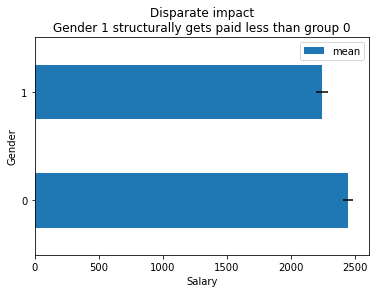

In [7]:
y_pred = utils.predict_series(lr, X_test)
y_pred_per_gender = y_pred.groupby(X_test['Gender']).agg(['mean', 'sem'])
ax = y_pred_per_gender.plot(y='mean', xerr='sem', kind='barh', title='Disparate impact\nGender 1 structurally gets paid less than group 0')
ax.set_xlabel('Salary')
plt.show()

In this case, there is definitely a disparate impact. That in itself, may already be enough to find the algorithm is unfair, but others may argue that experience and level of education are valuable to the company and that in fact should pay more. Therefore, let's quickly look into disparate treatment as well.

The model has a coefficient of -200 for gender 1 (closely mimicking the real, biased world), so there is a disparate treatment.

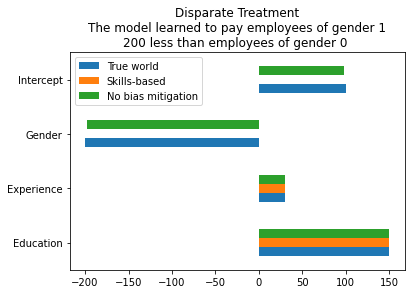

In [8]:
coefficients['No bias mitigation'] = utils.coefs_to_series(lr, X_train.columns.tolist())
coefficients.plot(kind='barh', title='Disparate Treatment\nThe model learned to pay employees of gender 1\n200 less than employees of gender 0 ')
plt.show()

The Disparate impact and Disparate treatment are also shown in the plot below. I calculate them as follows:  
**Calculating Disparate Impact**  
1. Disparate impact is the difference in average salary between the genders

**Calculating Disparate Treatment**
1. Calculate the difference between the skill-based salary and the predicted salary for each employee; which is the bias per employee
1. Calculate the mean bias per gender.
1. Disparate treatment is the difference between the two means calculated in the previous step.  
Note that I can only do step 1, because I generated the data, and therefore have access to the salary based purely on skills. 

Again, we see the model suffers from both disparate impact and disparate treatment.

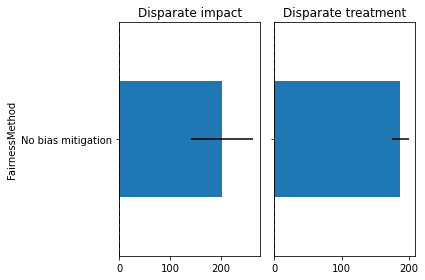

In [9]:
predictions = {'No bias mitigation': y_pred}

utils.plot_fairness_metrics(predictions, y_skill_test, X_test['Gender'])
plt.show()

## A generally inadequate bias mitigation approach: Unawareness
One way of dealing with this is 'Unawareness': drop the protected attributes and fit the model without it, so it does not account for the protected attribute.

In [10]:
X_train_unaware = X_train.drop(columns=['Gender'])
X_test_unaware = X_test.drop(columns=['Gender'])

In [11]:
lr_unaware = LinearRegression()
lr_unaware.fit(X_train_unaware, y_train)
print(f'The mean absolute error of the fitted model is {sklearn.metrics.mean_absolute_error(lr_unaware.predict(X_test_unaware), y_test): .2f} ')


The mean absolute error of the fitted model is  149.43 


At the cost of a bit of accuracy, the company now has a model that does not take Gender into account. Let's see what this does with out fairness measures.

In [12]:
y_pred_unaware = utils.predict_series(lr_unaware, X_test_unaware)

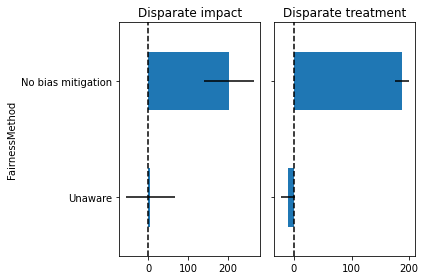

In [13]:
predictions['Unaware'] = y_pred_unaware

utils.plot_fairness_metrics(predictions, y_skill_test, X_test['Gender'])
plt.show()

So for this case, we now have a fair model on both metrics. Is this then the way to deal with sensitive attributes: just drop them from the data set? No. This toy dataset is unrealistic because there are no correlations

Unawareness is insufficient because in the real world the protected attribute often correlates with other, non-protected and perhaps even relevant attributes.

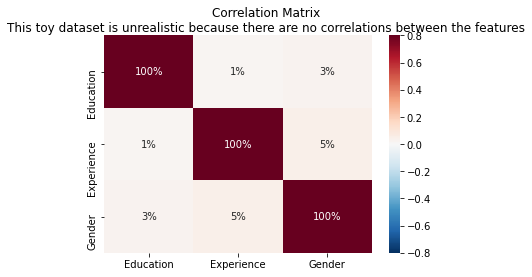

In [14]:
sns.heatmap(X_train.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.0%')
plt.suptitle('Correlation Matrix\nThis toy dataset is unrealistic because there are no correlations between the features')
plt.show()

## Unawareness only solves the problem for trivial toy datasets
In this part I will show that neither approach works if the protected attribute is in fact correlated with other attributes. This is almost always the case in real life, and often in very complicated ways.

For our example, let's investigate a simple case where due to societal expectations and developments a gender that is disadvantaged is also biased against in getting education and experience, as shown in the following process:

<img src="./Figures/DGP_Salary_Correlated.PNG" title="The data generating process for salary for an imaginary company with biases in employee salaries, where experience and education correlate with gender"/>

In [15]:
def generate_employees_correlated(size=2500):
    '''
    Generating employees, where attributes are correlated with gender
    
    Gender 1 generally has lower education and experience
    '''
    X = (pd.DataFrame({'Gender': np.random.randint(2, size=size),})
           .assign(Education = lambda df: 4 + 16 * np.random.rand(size) * np.where(df['Gender'] == 0, 1, np.random.rand(size)) ,
                   Experience = lambda df: (40*np.random.rand(size) + np.random.normal(df['Gender'].mul(-1).add(1).mul(10), 5)).clip(0, 40),
                  )
         
        )
    return X


In [16]:
df_corr = generate_employees_correlated().pipe(add_salaries)
display_df(df_corr)

,Gender,Education,Experience,SalarySkill,SalaryTrue
1447,0,16.21,40.00,€3927.44,€4025.99
1114,1,4.23,19.89,€1184.13,€1082.69
1064,1,14.80,20.63,€3007.49,€2906.06
2287,1,4.20,20.39,€1278.24,€1176.81
1537,0,4.25,29.69,€1632.36,€1730.91
668,0,18.64,19.81,€3281.88,€3380.43
1583,1,15.09,22.20,€3191.39,€3089.96
2404,0,5.21,22.85,€1260.05,€1358.60
497,1,4.01,38.34,€1802.39,€1700.96
2480,1,16.45,9.37,€2721.91,€2620.48


The table has the same columns, only the values are correlated now.

In [17]:
X_corr_train, X_corr_test, y_corr_train, y_corr_test, y_corr_skill_train, y_corr_skill_test = sklearn.model_selection.train_test_split(
                                                                                                         df_corr.filter(['Education', 'Experience', 'Gender', ]),
                                                                                                         df_corr['SalaryTrue'],
                                                                                                         df_corr['SalarySkill'])
X_corr_train_unaware = X_corr_train.drop(columns=['Gender']) # So we can train an unaware regressor
X_corr_test_unaware = X_corr_test.drop(columns=['Gender'])

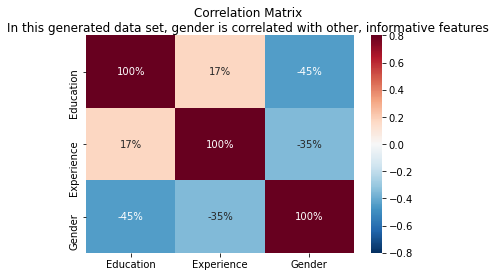

In [18]:
sns.heatmap(X_corr_train.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.0%')
plt.suptitle('Correlation Matrix\nIn this generated data set, gender is correlated with other, informative features')
plt.show()

### Training the same models on the new data set gives biased models

Again, we train the same two models as before: one where we do not apply any bias mitigation, and one _unaware_ model. While the the bias is not as bad in the unaware model as in the model that explicitly allows for the dependency, it is still clearly there, with people of Gender 1 getting ~50 less per month based on their gender. 

In [19]:
lr = LinearRegression()
lr.fit(X_corr_train, y_corr_train)
y_corr_pred = utils.predict_series(lr, X_corr_test)

In [20]:
lr_unaware = LinearRegression()
lr_unaware.fit(X_corr_train_unaware, y_corr_train)
y_corr_pred_unaware = utils.predict_series(lr_unaware, X_corr_test_unaware)

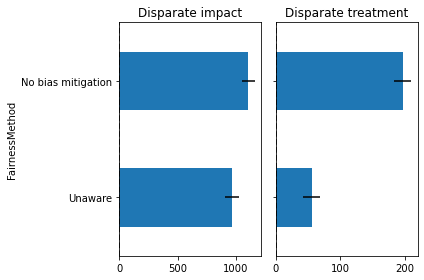

In [21]:
predictions = {'No bias mitigation': y_corr_pred,
               'Unaware': y_corr_pred_unaware,
                }

utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()

How is this possible if the model is unaware of Gender? Unawareness compensates the lack of direct information through correlated variables

The model _overestimates_ the importance of Experience and Education and through this keeps the biases partially intact. To keep the same mean salary, it also has a negative intercept: everyone is paid less, and then people with higher experience and education (mostly of Gender 1) are compensated.

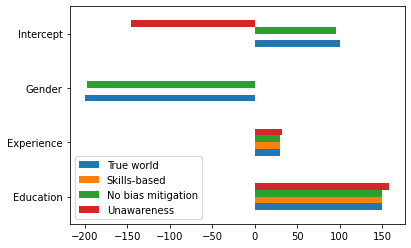

In [22]:
coefficients['No bias mitigation'] = utils.coefs_to_series(lr, X_corr_train.columns.tolist())
coefficients['Unawareness'] = utils.coefs_to_series(lr_unaware, X_corr_train_unaware.columns.tolist())

coefficients.plot(kind='barh')
plt.show()

## Removing the disparate treatment with the IgnoringBiasEstimator

So we conclude that something must be done to  reach a fair algorithm. Therefore, I built the `IgnoringBiasEstimator` which learns the biases in the data and ignores them at prediction.

There are generally 3 moments to work towards fairness, which I will quickly describe. For more information, see e.g. [here](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)
* During **preprocessing** by transforming the dataset in such a way that downstream estimators learn in a fair way. Note that dropping protected attributes was in this category (in a very naive way), but much more sophisticated approaches exist. A great advantage is that you no longer need the protected attributes after this is done, but it generally does not reach the performance (both in terms of fairness and accuracy) of the other approaches.
* During **inprocessing** by modifying the estimator (be it a classifier or a regressor) and the loss function (or constraints for this). This is generally harder from a technical perspective, but may reach very good results for a given definition of fairness.
* During **postprocessing**, which is the most flexible, but as a drawback does require access to protected attributes at test time. 

### The workings of the IgnoringBiasEstimator
What I will is use inprocessing modification of the algorithm, by combining the two unsuccesfull approaches applied above:
* The first model had access to the protected attribute - and we clearly saw how biased it learned to be during training
* The second model did not have access - and this was better during prediction, but had an unfortunate effect during training where it learned biases through other variables.

I will combine this by learning the biases during fitting and then *ignoring them at prediction time*. The fact that the model has access to the sensitive attributes during training prevents the model from learning the biases through other variables (which is what happened in the unaware model). Then, when predicting new instances, the protected attribute is hidden (in our example: the Gender) and filled with a neutral value for all instances (by default, this is the mean, but a custom value can be chosen). This allows us to discard the biases to work towards fairer salaries.


The implementation is available on [my Github](https://github.com/SjoerdCor/fairness/blob/main/fairestimator.py).

### Applying the IgnoringBiasEstimator: simple and effective


When applying the IgnoringBiasEstimator, you'll see two twings:
1. The IgnoringBiasEstimator is very easy to apply: it's just a wrapper around the fundamental estimator we're using (in our case, a simple LinearRegression) and the user has to indicate which column contains the sensitive attribute. Note that because of this, it is also very flexible: it can be used everything that's in `scikit-learn`: from a simple LinearRegression to more complex models such as Gradient Boosting.   You also specify the index of the column which should be ignored at prediction time.
1. It's effective: the disparate treatment is fully gone.

In [23]:
ib = fairestimator.IgnoringBiasRegressor(LinearRegression(), ignored_cols=[-1]) # Ignore the Gender at prediction time, which is encoded in the last column
ib.fit(X_corr_train, y_corr_train)
y_corr_pred_ib = utils.predict_series(ib, X_corr_test)

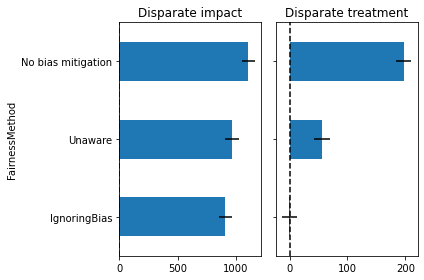

In [24]:
predictions['IgnoringBias'] = y_corr_pred_ib
utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()



### Additional advantage: the method can give insight into the biases at play here
A bonus of this approach is that the model learned all the biases, and by observing what the model learned, a user might be able to influence the real world. For this, I like the [partial dependence plot](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html). It shows the expected output for a given input. In the plot below, it can be seen that the salary increases with increasing Education and Experience, but is lower for Gender 1 than for Gender 0 (during training - not during prediction, since it is hidden during prediction). While in this case, this was already clear from the plots before, the partial dependence plot can be very useful for more complex, non-parametric models (unlike the simple Linear Regression I performed) and/or non-linear biases. I will investigate that in Part 2 of this series about fairness.

We might use this to influence the real world; understanding where it comes from and perhaps training the people responsible for it to prevent it from happening.

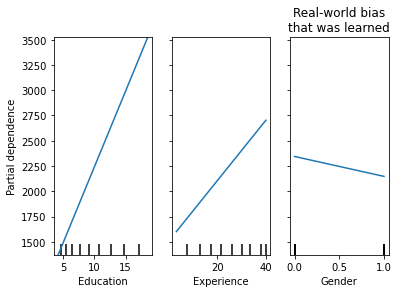

In [25]:
pdd = plot_partial_dependence(ib.estimator, X_corr_train, X_corr_train.columns)
pdd.axes_[0][2].set_title('Real-world bias\nthat was learned')
plt.show()

## Two closing remarks on fairness
Before concluding this blog, I would like to share two general remarks on fairness in AI:

* There is a trade-off between disparate impact and disparate treatment
* Fairness does not hurt the true accuracy

### There is a trade-off between disparate impact and disparate treatment
For some people or use cases, removing disparate treatment might be the definition of fair. For others, it might not be: there is still a disparate impact where employees of Gender 1 get a lower salary of ~900 a month, due to their lower experience and education on average, which may in turn be driven by societal biases. What you should note though, is that is a choice, and you cannot have it both ways. Below, I train a model that has a Disparate Impact of 0. This on the other hand leads to a disparate treatment towards employees of gender 0: for equal experience and education, they would now receive a lower salary. There is no fundamental good or bad - this is a matter of vision.

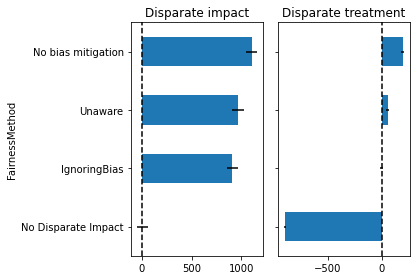

In [26]:
lr_di = copy.deepcopy(lr)
lr_di.coef_[2] = 900
y_corr_pred_di = utils.predict_series(lr_di, X_corr_test)

predictions['No Disparate Impact'] = y_corr_pred_di
utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()

In [27]:
del predictions['No Disparate Impact']

### Fairness does not hurt the true accuracy
A lot of places state that there is a trade-off beteween fairness and accuracy. I disagree. The trade-off is only there because we do not observe what we would like to observe. Improving fairness you might decrease the _observed_ accuracy (which would still be worth it), but we do not _want_ to match the observed salaries in the first place - the whole point was to remove the biases that we see in the real world. In fact, the plots below show that the predictions of match the skills-based salaries _better_ when improving fairness. The only thing is that in a real world application we would not have access to those. But it is still very important to keep in mind that accuracy only decreases because we observe bad targets.

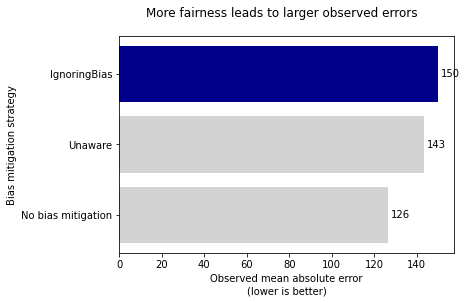

In [28]:
measurable_accuracy = {name: sklearn.metrics.mean_absolute_error(y_pred, y_corr_test)
                       for name, y_pred in predictions.items()}
ax = plt.barh(range(len(measurable_accuracy)), measurable_accuracy.values(), color=['lightgrey', 'lightgrey', 'darkblue', 'lightgrey'])
plt.bar_label(ax, fmt='%d', padding=3)
plt.yticks(range(len(measurable_accuracy)), measurable_accuracy.keys())
plt.suptitle('More fairness leads to larger observed errors')
plt.ylabel("Bias mitigation strategy")
plt.xlabel('Observed mean absolute error\n(lower is better)')
plt.show()

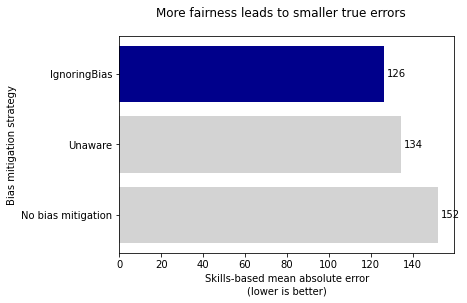

In [29]:
true_accuracy = {name: sklearn.metrics.mean_absolute_error(y_pred, y_corr_skill_test)
                 for name, y_pred in predictions.items()}
ax = plt.barh(range(len(true_accuracy)), true_accuracy.values(), color=['lightgrey', 'lightgrey', 'darkblue', 'lightgrey'])
plt.bar_label(ax, fmt='%d', padding=3)
plt.yticks(range(len(true_accuracy)), true_accuracy.keys())
plt.ylabel("Bias mitigation strategy")
plt.xlabel('Skills-based mean absolute error\n(lower is better)')
plt.suptitle('More fairness leads to smaller true errors')
plt.show()

## Conclusion and outlook
In this blog series, I quickly introduced the problem of bias in AI models, due to biased datasets and inadequate bias mitigation. Passive bias mitigation through either ignoring bias exists and leaving the sensitive attributes in the dataset, or dropping the sensitive attribute and then ignoring the problem propage biases into biased models. Furthermore, I quickly introduced two notions of fairness: disparate treatment (or different _decisions_ for sensitive groups) versus disparate impact (or different _outcomes_ for senstive groups).


As a solution, I propsed the IgnoringBiasEstimator and saw the following things:
* It was in fact very easy to use,
* It worked very well to remove the disparate treatment
* It gives insight into the biases at play. 

In the following installment of this series, I will show how flexible it is with continuous sensitive attributes and non-linear biases and classification targets and compare it to other bias mitigation strategies. I hope this will contribute to more fairness in decision processes.